In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/leash-BELKA/sample_submission.csv
/kaggle/input/leash-BELKA/train.parquet
/kaggle/input/leash-BELKA/test.parquet
/kaggle/input/leash-BELKA/train.csv
/kaggle/input/leash-BELKA/test.csv


In [3]:
!pip install duckdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 53.7 MB/s eta 0:00:00:00:0100:01


In [4]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 42.6 MB/s eta 0:00:00:00:0100:01


In [5]:
import duckdb
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from scipy.stats import chi2_contingency

In [6]:
train_path = '/kaggle/input/leash-BELKA/train.parquet'
#test_path = '/kaggle/input/leash-BELKA/test.parquet'

con = duckdb.connect()

one_binds = con.query(f"""(SELECT count(*)
                FROM parquet_scan('{train_path}')
                WHERE binds = 1)
""").fetchone()[0]

df_train = con.query(f"""(SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 0
                        ORDER BY random()
                        LIMIT {one_binds}*2)
                        UNION ALL
                        (SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 1)""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [5]:
# df_test=conn.query(f"""(SELECT * FROM parquet_scan('{test_path}'))""").df()

In [7]:
df_train.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,74705162,O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,Cl.NCCOCC(F)F,NCc1nc(-c2ccsc2)no1,O=C(N[Dy])C(Cc1ccccc1)Nc1nc(NCCOCC(F)F)nc(NCc2...,sEH,0
1,245480892,O=C(O)C[C@@H](Cc1ccc(Cl)c(Cl)c1)NC(=O)OCC1c2cc...,Cc1cc(F)ccc1N,CC(C)(C)OC(=O)n1ncc2cc(N)ccc21,Cc1cc(F)ccc1Nc1nc(Nc2ccc3c(cnn3C(=O)OC(C)(C)C)...,BRD4,0
2,3235635,C#CC[C@@](C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,Nc1ncc(Cl)cc1F,Nc1cc(Cl)c(F)c(Cl)c1,C#CC[C@@](C)(Nc1nc(Nc2cc(Cl)c(F)c(Cl)c2)nc(Nc2...,BRD4,0
3,240158400,O=C(O)CNC(=O)OCC1c2ccccc2-c2ccccc21,Cl.Cl.NCCNC(=O)c1cnccn1,Cl.NCc1cnc(Cl)s1,O=C(CNc1nc(NCCNC(=O)c2cnccn2)nc(NCc2cnc(Cl)s2)...,BRD4,0
4,219105678,O=C(Nc1cnc(Cl)cc1C(=O)O)OCC1c2ccccc2-c2ccccc21,CCOCCCN,NCC1(N2CCOCC2)CC1,CCOCCCNc1nc(NCC2(N3CCOCC3)CC2)nc(Nc2cnc(Cl)cc2...,BRD4,0


In [8]:
df_train.count()

id                       4769718
buildingblock1_smiles    4769718
buildingblock2_smiles    4769718
buildingblock3_smiles    4769718
molecule_smiles          4769718
protein_name             4769718
binds                    4769718
dtype: int64

In [9]:
def calculate_molecular_weight(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Descriptors.MolWt(mol)
        else:
            return None
    except:
        return None

# Add molecular weight column
df_train['molecular_weight'] = df_train['molecule_smiles'].apply(calculate_molecular_weight)

In [10]:
df_train['molecular_weight']

0          707.068
1          842.064
2          689.242
3          625.407
4          667.503
            ...   
4769713    717.171
4769714    591.954
4769715    618.976
4769716    658.057
4769717    669.970
Name: molecular_weight, Length: 4769718, dtype: float64

In [11]:
# Define weight bins
bins = [0, 200, 400, 600, 800, 1000, float('inf')]  # Example bins
labels = ['<200', '200-400', '400-600', '600-800', '800-1000', '>1000']

# Bin the molecular weights
df_train['weight_bin'] = pd.cut(df_train['molecular_weight'], bins=bins, labels=labels)
print(df_train[['molecular_weight', 'weight_bin', 'binds']])

         molecular_weight weight_bin  binds
0                 707.068    600-800      0
1                 842.064   800-1000      0
2                 689.242    600-800      0
3                 625.407    600-800      0
4                 667.503    600-800      0
...                   ...        ...    ...
4769713           717.171    600-800      1
4769714           591.954    400-600      1
4769715           618.976    600-800      1
4769716           658.057    600-800      1
4769717           669.970    600-800      1

[4769718 rows x 3 columns]


In [14]:
from scipy.stats import chi2_contingency

results = {}

for protein, group in df_train.groupby('protein_name'):
    # Create contingency table
    contingency_table = pd.crosstab(group['weight_bin'], group['binds'])
    
    # Perform chi-square test
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Store results
    results[protein] = {
        'chi2_stat': chi2_stat,
        'p_value': p_value,
        'dof': dof,
        'expected': expected,
        'observed': contingency_table.values
    }
    print(f"\nProtein: {protein}")
    print(f"Contingency Table for Observed Frequencies:\n{contingency_table}")
    print(f"Chi-Square Statistic: {chi2_stat}")
    print(f"P-value: {p_value}")
    print(f"Degrees of Freedom: {dof}")
    print("Expected Frequencies Table:")
    print(expected)


Protein: BRD4
Contingency Table for Observed Frequencies:
binds            0       1
weight_bin                
400-600      11563    2675
600-800     840474  366637
800-1000    203522   87386
>1000         4482     266
Chi-Square Statistic: 2262.2281732685706
P-value: 0.0
Degrees of Freedom: 3
Expected Frequencies Table:
[[  9949.11932261   4288.88067739]
 [843495.67176839 363615.32823161]
 [203278.43825696  87629.56174304]
 [  3317.77065204   1430.22934796]]

Protein: HSA
Contingency Table for Observed Frequencies:
binds            0       1
weight_bin                
400-600      11753    6339
600-800     840433  344741
800-1000    204658   56388
>1000         4517     942
Chi-Square Statistic: 6753.700853182227
P-value: 0.0
Degrees of Freedom: 3
Expected Frequencies Table:
[[ 13064.71770909   5027.28229091]
 [855845.88470857 329328.11529143]
 [188508.30748872  72537.69251128]
 [  3942.09009363   1516.90990637]]

Protein: sEH
Contingency Table for Observed Frequencies:
binds       

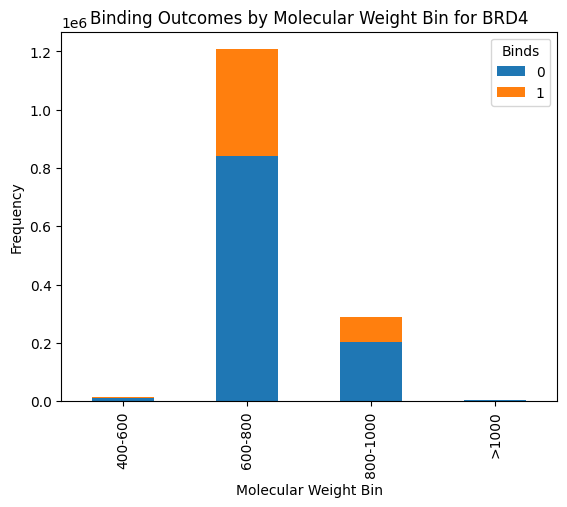

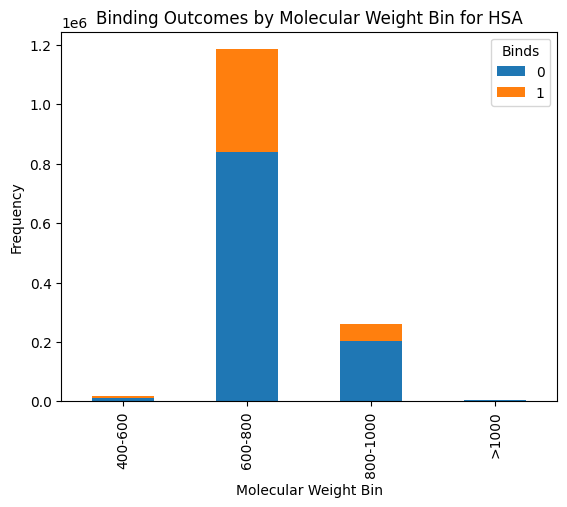

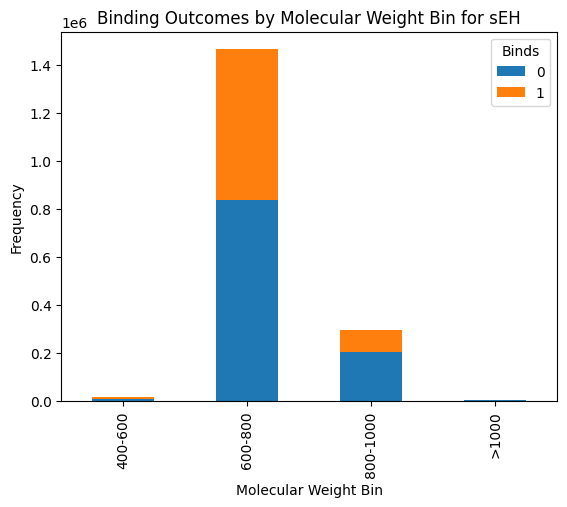

In [15]:
import matplotlib.pyplot as plt

for protein, group in df_train.groupby('protein_name'):
    contingency_table = pd.crosstab(group['weight_bin'], group['binds'])
    contingency_table.plot(kind='bar', stacked=True)
    plt.title(f'Binding Outcomes by Molecular Weight Bin for {protein}')
    plt.xlabel('Molecular Weight Bin')
    plt.ylabel('Frequency')
    plt.legend(title='Binds')
    plt.show()